In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('Morgan_desc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 2049 entries, Yield to 1023.1
dtypes: int64(2049)
memory usage: 1.1 MB


In [3]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 1914 variables with zero variance
the number of variable is: [   1    2    3 ... 2046 2047 2048]
remove them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 135 entries, Yield to 919.1
dtypes: int64(135)
memory usage: 71.8 KB


In [4]:
#Building descriptors
X = df_var0.drop(columns=['Yield'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   8  9  15  33  58  63  64  68  80  102  ...  623.1  665.1  695.1  726.1  \
0  0  0   0   0   0   0   1   0   0    0  ...      1      1      1      0   
1  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      0   
2  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      1   
3  0  0   0   0   0   0   1   0   0    0  ...      0      0      0      0   
4  0  0   0   1   0   0   0   0   0    0  ...      1      1      1      0   

   755.1  802.1  807.1  841.1  849.1  919.1  
0      0      1      0      1      0      0  
1      1      0      1      0      0      0  
2      0      0      1      0      1      1  
3      0      0      1      0      0      0  
4      0      1      0      1      0      0  

[5 rows x 134 columns]
---Objective---
   Yield
0     80
1      7
2      3
3     48
4     99


In [6]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_imp=pd.Series(index = X.columns)
cum_imp.fillna(0, inplace=True)

#RF_a_X
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 
    a_X_train=a_X_train.dropna(axis=1)
    a_X_test=a_X_test.dropna(axis=1)

    param_grid = {"max_depth":[2,3,4,5],
                  'n_estimators':[1000,3000,5000]} 
    reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
    reg_rf.fit(a_X_train,y_train['Yield'])
    reg_best = reg_rf.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)
    y_pred2 = reg_best.predict(a_X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    parametors = reg_rf.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_rf.best_score_)

    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_rf.best_params_)
    print("Best Model Score:",reg_rf.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


----------------------
seed: 0
Best Model Parameter: {'max_depth': 3, 'n_estimators': 3000}
Best Model Score: 0.8169682382726597
R2_test: 0.7119152479931301
----------------------
seed: 1
Best Model Parameter: {'max_depth': 5, 'n_estimators': 5000}
Best Model Score: 0.7323642620386025
R2_test: 0.8358368691558298
----------------------
seed: 2
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.7698464459813824
R2_test: 0.8032466238553859
----------------------
seed: 3
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.7472141373786514
R2_test: 0.8170357707853921
----------------------
seed: 4
Best Model Parameter: {'max_depth': 4, 'n_estimators': 3000}
Best Model Score: 0.7936659284441786
R2_test: 0.7301178480700681
----------------------
seed: 5
Best Model Parameter: {'max_depth': 4, 'n_estimators': 1000}
Best Model Score: 0.8059967170104715
R2_test: 0.7436445369715863
----------------------
seed: 6
Best Model Parameter: {'max

In [8]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)
data_all.to_csv('../../score/MorganF/RF_score.csv')

      r2_train   MSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.940144   44.129633   4.364488  0.711915  376.800484  11.504317   
1     0.944138   50.516668   4.240595  0.835837  159.049133   8.273172   
2     0.862892  126.838857   6.992406  0.803247  190.272561   8.008248   
3     0.857957  132.484680   6.930770  0.817036  175.599193   8.398523   
4     0.946444   46.170386   4.296597  0.730118  286.972240  10.464010   
5     0.949894   40.573003   3.733536  0.743645  311.780560  11.152953   
6     0.874212  103.230813   6.348879  0.727212  328.289459  10.744317   
7     0.882591  112.301814   6.682544  0.739246  236.375418   9.848129   
8     0.878069  107.313424   6.234670  0.744573  252.421836  10.949838   
9     0.823469  178.904205   8.553738  0.908126   64.739924   5.320798   
mean  0.895981   94.246348   5.837822  0.776095  238.230081   9.466430   

      cv_score  
0     0.816968  
1     0.732364  
2     0.769846  
3     0.747214  
4     0.793666  
5     0.8

In [8]:
cum_imp.sort_values(ascending=False,inplace=True)
cum_imp

P_MinEStateIndex       4.392055
P_VSA_EState9          4.187760
Cate_MinEStateIndex    0.136644
Cate_EState_VSA7       0.087431
Cate_VSA_EState6       0.059235
                         ...   
Cate_VSA_EState9       0.000056
Cate_fr_methoxy        0.000054
Cate_SlogP_VSA1        0.000043
Cate_PEOE_VSA14        0.000010
Cate_Ipc               0.000000
Length: 160, dtype: float64

In [9]:
# feature importance 
importances = pd.Series(reg_best.feature_importances_, index = X.columns)
importances = importances.sort_values(ascending=False)
importances.head()

P_MinEStateIndex       0.462443
P_VSA_EState9          0.388968
Cate_EState_VSA7       0.030722
Cate_MinEStateIndex    0.022166
Cate_Chi2n             0.011220
dtype: float64

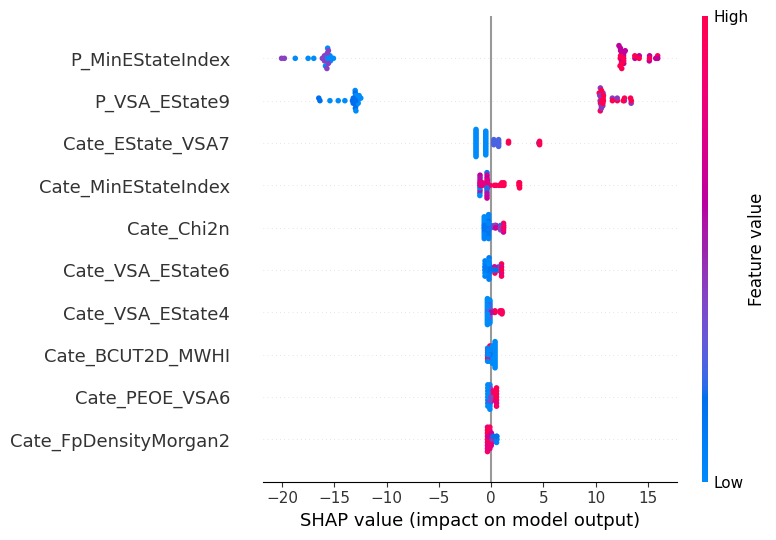

In [11]:
#shap
explainer = shap.TreeExplainer(reg_best)
shap_values = explainer.shap_values(X=a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=10)

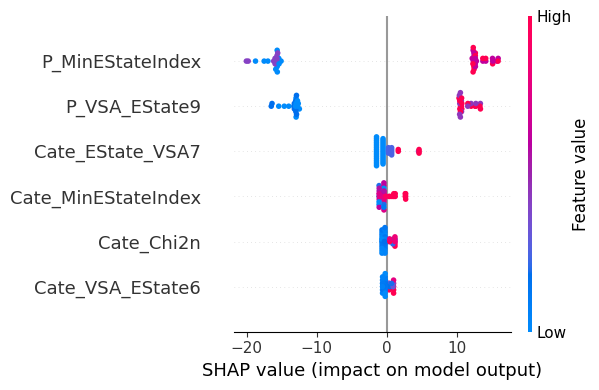

In [12]:
shap.summary_plot(shap_values, X_train,max_display=6, plot_size=(6,4))

In [8]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_imp=pd.Series(index = X.columns)
cum_imp.fillna(0, inplace=True)

#RF
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    param_grid = {"max_depth":[2,3,4,5],
                  'n_estimators':[1000,3000,5000]} 
    reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
    reg_rf.fit(X_train,y_train['Yield'])
    reg_best = reg_rf.best_estimator_
    y_pred1 = reg_best.predict(X_train)
    y_pred2 = reg_best.predict(X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    parametors = reg_rf.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_rf.best_score_)
    
    #cumulative importances 
    importances = pd.Series(reg_best.feature_importances_, index = X.columns)
    cum_imp += importances
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_rf.best_params_)
    print("Best Model Score:",reg_rf.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


----------------------
seed: 0
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7875762557517849
R2_test: 0.7453524421761931
----------------------
seed: 1
Best Model Parameter: {'max_depth': 4, 'n_estimators': 1000}
Best Model Score: 0.7370052789283722
R2_test: 0.8560333085832441
----------------------
seed: 2
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7681803107459162
R2_test: 0.7782171278578958
----------------------
seed: 3
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7447516651249237
R2_test: 0.7996681258425917
----------------------
seed: 4
Best Model Parameter: {'max_depth': 4, 'n_estimators': 3000}
Best Model Score: 0.8056116904277865
R2_test: 0.7438958014419593
----------------------
seed: 5
Best Model Parameter: {'max_depth': 4, 'n_estimators': 1000}
Best Model Score: 0.8051567803642794
R2_test: 0.8410601114780861
----------------------
seed: 6
Best Model Parameter: {'max

In [9]:
cum_imp.sort_values(ascending=False,inplace=True)
cum_imp

P_VSA_EState9            4.254623
P_MinEStateIndex         4.209335
Cate_MinEStateIndex      0.162595
Cate_EState_VSA7         0.064233
Cate_FpDensityMorgan2    0.052257
                           ...   
Cate_SlogP_VSA7          0.000036
Cate_PEOE_VSA14          0.000020
Cate_VSA_EState9         0.000011
Cate_fr_ester            0.000006
Cate_SlogP_VSA1          0.000005
Length: 165, dtype: float64